In [ ]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

print("HuggingFace Transformers + PyTorch loaded successfully!")


HuggingFace Transformers + PyTorch loaded successfully!


In [ ]:
!pip install -q transformers datasets accelerate

In [ ]:
# Imports
import pandas as pd
import numpy as np
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import load_dataset, Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [ ]:
df = pd.read_csv('cleaned_labeled_tweets.csv')
df = df[df['label'].isin([0, 1, 2])]
df.head()


,id,final_text,label
0,1601363673259290880,साम्पाङ बालेन गाउँपालिका नगरपालिका वडामा जनप्र...,2.0
1,1601226348013707008,जनप्रतिनिधि सर्वोच्च न्यायाधीश महाभियोग पर्छ।,2.0
2,1601225158538117120,"अत्याचार पास हो, जनप्रतिनिधि झुठो बोलेर पास पद",2.0
3,1601130318731259904,सत्तारुढ गठबन्धनका नेताहरू सरकारमा अख्तियार गर...,2.0
5,1601417900241595904,क्षेत्रमा खराब छैनन खराब राजनीति दल निकट आबद्ध,2.0


In [ ]:
# Converting to Hugging Face Dataset
df["label"] = df["label"].astype(int)
dataset = Dataset.from_pandas(df)


# Tokenization
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")

def tokenize_fn(batch):
    return tokenizer([str(x) for x in batch["final_text"]], truncation=True, padding=True)

tokenized_ds = dataset.map(tokenize_fn, batched=True)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Map:   0%|          | 0/75826 [00:00<?, ? examples/s]

In [ ]:
# Splitting to Train-Test Split
split_ds = tokenized_ds.train_test_split(test_size=0.2)



In [ ]:
# Defining Metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

model = AutoModelForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=3)

# Training Arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to=[],
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=split_ds["train"],
    eval_dataset=split_ds["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

NameError: name 'AutoModelForSequenceClassification' is not defined

📊 Classification Report:
              precision    recall  f1-score   support

     Neutral       0.81      0.53      0.64       874
    Positive       0.77      0.82      0.79      9016
    Negative       0.67      0.65      0.66      5276

    accuracy                           0.74     15166
   macro avg       0.75      0.66      0.70     15166
weighted avg       0.74      0.74      0.74     15166



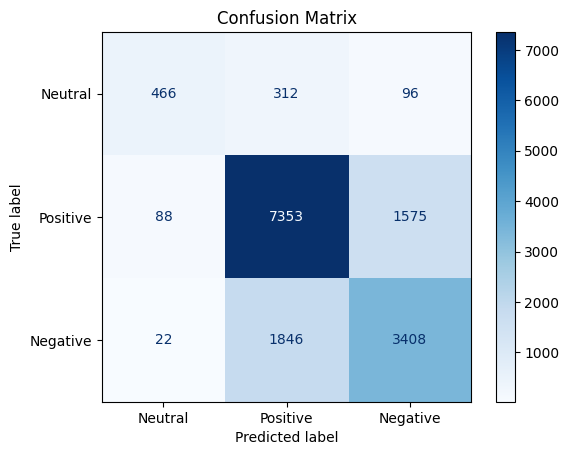

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Get predictions
predictions = trainer.predict(split_ds["test"])
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

# Classification Report
print("📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Neutral", "Positive", "Negative"]))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Neutral", "Positive", "Negative"])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()


In [ ]:
model_path = "nepali-sentiment-model-xlmr"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)
print(f"✅ Model saved to {model_path}")

✅ Model saved to nepali-sentiment-model-xlmr


In [ ]:
# Defining a Prediction Function for new tweets
from transformers import pipeline

# Loading Pipeline
sentiment_pipeline = pipeline("text-classification", model=model_path, tokenizer=model_path)

# Define custom label mapping (if needed)
label_map = {
    "LABEL_0": "Neutral",
    "LABEL_1": "Positive",
    "LABEL_2": "Negative"
}


def predict_sentiment(text):
    result = sentiment_pipeline(text)[0]
    label = label_map.get(result['label'], result['label'])
    return f"📝 Text: {text}\n🔍 Sentiment: {label} (Confidence: {result['score']:.2f})"

Device set to use cuda:0


In [ ]:
print(predict_sentiment("नेपाली जनताको विश्वास गुमाउँदैछन् राजनीतिक दलहरू।"))

📝 Text: नेपाली जनताको विश्वास गुमाउँदैछन् राजनीतिक दलहरू।
🔍 Sentiment: Negative (Confidence: 0.75)


In [ ]:
texts = [
    "प्रधानमन्त्रीको निर्णयले देशको भविष्य उज्यालो बनाउनेछ।",
    "सरकारको भ्रष्टाचारले जनतामा निराशा फैलिएको छ।",
    "चुनावमा सबै उम्मेदवारहरुले जनताको भावना बुझ्नुपर्छ।",
    "नेकपाको घोषणापत्र निकै आशाजनक देखिन्छ।",
    "विपक्षी दलको आरोप निराधार छ भन्ने लाग्दैन।",
    "देश विकास होइन, विनाशतिर गइरहेको जस्तो देखिन्छ।",
    "अहिलेको सरकारले शिक्षा र स्वास्थ्य क्षेत्रमा राम्रो काम गरिरहेको छ।",
    "नेताहरूको भाषण मात्रै हुन्छ, काम शून्य हुन्छ।",
    "आगामी निर्वाचनमा मेरो मत परिवर्तन हुन सक्छ।",
    "नेपाली जनताको विश्वास गुमाउँदैछन् राजनीतिक दलहरू।"
]

for text in texts:
    print(predict_sentiment(text))


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


📝 Text: प्रधानमन्त्रीको निर्णयले देशको भविष्य उज्यालो बनाउनेछ।
🔍 Sentiment: Positive (Confidence: 0.99)
📝 Text: सरकारको भ्रष्टाचारले जनतामा निराशा फैलिएको छ।
🔍 Sentiment: Negative (Confidence: 0.90)
📝 Text: चुनावमा सबै उम्मेदवारहरुले जनताको भावना बुझ्नुपर्छ।
🔍 Sentiment: Positive (Confidence: 0.98)
📝 Text: नेकपाको घोषणापत्र निकै आशाजनक देखिन्छ।
🔍 Sentiment: Positive (Confidence: 0.98)
📝 Text: विपक्षी दलको आरोप निराधार छ भन्ने लाग्दैन।
🔍 Sentiment: Negative (Confidence: 0.87)
📝 Text: देश विकास होइन, विनाशतिर गइरहेको जस्तो देखिन्छ।
🔍 Sentiment: Negative (Confidence: 0.83)
📝 Text: अहिलेको सरकारले शिक्षा र स्वास्थ्य क्षेत्रमा राम्रो काम गरिरहेको छ।
🔍 Sentiment: Positive (Confidence: 0.99)
📝 Text: नेताहरूको भाषण मात्रै हुन्छ, काम शून्य हुन्छ।
🔍 Sentiment: Negative (Confidence: 0.91)
📝 Text: आगामी निर्वाचनमा मेरो मत परिवर्तन हुन सक्छ।
🔍 Sentiment: Positive (Confidence: 0.99)
📝 Text: नेपाली जनताको विश्वास गुमाउँदैछन् राजनीतिक दलहरू।
🔍 Sentiment: Negative (Confidence: 0.75)


# **Error Analysis**

In [ ]:
predictions = trainer.predict(split_ds["test"])
pred_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

In [ ]:
# Attaching Predictions to Original Data

import pandas as pd

# Convert to DataFrame
df_test = split_ds["test"].to_pandas()
df_test["true_label"] = true_labels
df_test["pred_label"] = pred_labels

In [ ]:
df_test.shape

(15166, 8)

In [ ]:
# Filtering Misclassified Examples
# Only keep rows where prediction != actual
misclassified_df = df_test[df_test["true_label"] != df_test["pred_label"]]
misclassified_df = misclassified_df.reset_index(drop=True)

In [ ]:
# Mapping Label IDs to Sentiment Names
label_map = {0: "Neutral", 1: "Positive", 2: "Negative"}

misclassified_df["true_sentiment"] = misclassified_df["true_label"].map(label_map)
misclassified_df["predicted_sentiment"] = misclassified_df["pred_label"].map(label_map)


In [ ]:
# Insights
print("Total Test Data Shape", df_test.shape)
print("Shape of Misclassified Tweets", misclassified_df.shape)
print("Top Misclassfied Tweets:")
misclassified_df[["final_text", "true_sentiment", "predicted_sentiment"]].head(20)


Total Test Data Shape (15166, 8)
Shape of Misclassified Tweets (3939, 10)
Top Misclassfied Tweets:


,final_text,true_sentiment,predicted_sentiment
0,प्रचण्ड चितवन छोरी हराउने अभिव्यक्ति चुनाब पूर...,Positive,Negative
1,अस्थिरता नाइके प्रचन्डको गठबन्धन बर्ष अडान लिय...,Positive,Negative
2,यै पाराले पुन: भोट,Negative,Positive
3,घाम लगाउने उमेदबार काठमाडौं उपयुक्त भजन जित ।।,Negative,Positive
4,डाक्टर मलेसिया पठाउन,Negative,Positive
5,स्थानिय निर्वाचनमा उम्मेदवारले मत पाए निर्वाचन...,Neutral,Positive
6,खारेज भैसकेको पुरानो नागरिकता उम्मेदवार स्पष्ट...,Positive,Negative
7,"हामि श्रोत चैं तेही थियो, दैनिक चैं",Positive,Negative
8,"भिडन्त हुनुपर्ने नगरपालिका, बर्दियाको रे।",Positive,Negative
9,छैन। रूपमा याे भाषा पढेको छैन। संचार हाे। नेपा...,Positive,Negative


## Confusion Breakdown Per Sentiment

In [ ]:
# Generating Confusion Matrix
from sklearn.metrics import confusion_matrix
import pandas as pd

# Assuming your labels are: 0 = Neutral, 1 = Positive, 2 = Negative
label_names = ["Neutral", "Positive", "Negative"]
cm = confusion_matrix(true_labels, pred_labels)

# Convert to DataFrame for better readability
cm_df = pd.DataFrame(cm, index=[f"Actual {l}" for l in label_names],
                        columns=[f"Predicted {l}" for l in label_names])

print("Confusion Matrix Breakdown:")
print(cm_df)


Confusion Matrix Breakdown:
                 Predicted Neutral  Predicted Positive  Predicted Negative
Actual Neutral                 466                 312                  96
Actual Positive                 88                7353                1575
Actual Negative                 22                1846                3408


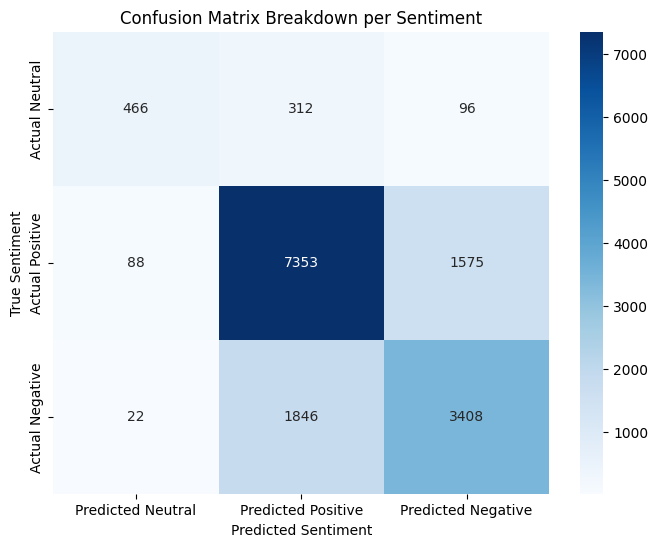

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix Breakdown per Sentiment")
plt.ylabel("True Sentiment")
plt.xlabel("Predicted Sentiment")
plt.show()


### Observation of Error Analysis
Positive sentiment is detected most accurately, with high precision and recall.

Negative sentiment is often misclassified as Positive, suggesting overlapping language or sarcasm in critical tweets.

Neutral tweets are frequently confused with Positive, likely due to subtle or mild language.




## **Pipeline for Real World Tweets**

In [ ]:
# Fetching the Tweets from Twitter Api
import tweepy
import pandas as pd

# ✅ Replace with your own Bearer Token
BEARER_TOKEN = "AAAAAAAAAAAAAAAAAAAAAO0c3AEAAAAA5K1F00mhGPcO5mHbRTe87xJHBMU%3DyWh4fIbVLFXmBz6jtXBRKzjanpLL3FugcxHo3KuNCnJK7HQCeL"
# bearer_token = "YOUR_BEARER_TOKEN"
client = tweepy.Client(bearer_token=BEARER_TOKEN)

# 🔍 Query for Nepali tweets on political topics
query = "(नेपाल OR प्रधानमन्त्री OR राजनीति OR गठबन्धन OR चुनाव OR संसद) lang:ne -is:retweet"



In [ ]:
# Function to fetch nepali Tweets
def fetch_nepali_political_tweets(max_results=50):
    tweets = client.search_recent_tweets(query=query, tweet_fields=["lang", "created_at"], max_results=max_results)
    return [tweet.text for tweet in tweets.data] if tweets.data else []


In [ ]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 6.8 MB/s eta 0:00:00


In [ ]:
# Cleaning the Tweets
import re
import emoji

with open("nepali_stopwords.txt", "r", encoding="utf-8") as f:
    stopwords = set(f.read().splitlines())

def clean_tweet(text):
    if pd.isnull(text):
        return ""
    text = emoji.replace_emoji(text, replace="")
    text = re.sub(r"[\u200c\u200d\u200e\u200f\u202a-\u202e]", "", text)
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"#\w+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"[a-zA-Z0-9०-९।!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~]", "", text)
     # Remove punctuation (both Latin and Devanagari punctuation)
    text = re.sub(r"[।!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~]", "", text)

    # Remove Latin letters and digits
    text = re.sub(r"[a-zA-Z0-9०-९]", "", text)
    words = text.strip().split()
    words = [w for w in words if w not in stopwords and 2 <= len(w) <= 20]
    return " ".join(words)

In [ ]:
# Running Predictions Using the Trained Model

from transformers import pipeline

model_path = "nepali-sentiment-model-xlmr"
# Loading fine-tuned model
sentiment_pipeline = pipeline("text-classification",
                              model=model_path,
                              tokenizer=model_path,
                              )

label_map = {
    "LABEL_0": "Neutral",
    "LABEL_1": "Positive",
    "LABEL_2": "Negative"
}

def predict_sentiment(text):
    result = sentiment_pipeline(text)[0]
    label = label_map.get(result['label'], result['label'])
    return label, result['score']


Device set to use cpu


In [ ]:
# Inference and Results

tweets = fetch_nepali_political_tweets(max_results=50)

results = []
for tweet in tweets:
    cleaned = clean_tweet(tweet)
    if cleaned:
        label, score = predict_sentiment(cleaned)
        results.append({
            "text": cleaned,
            "sentiment": label,
            "confidence": round(score, 2)
        })

# Show outcomes
import pandas as pd
df_results = pd.DataFrame(results)
df_results.head(10)

,text,sentiment,confidence
0,सत्ताको हड्डी चुस्न बानि यताका दुईचार अराजक झु...,Negative,0.72
1,"चोर,गोरुचोर जेलभित्र बसेर अपराध काट्दैछ्न् उन्...",Negative,0.81
2,प्रधानमन्त्री भएपछि,Positive,0.69
3,"घिन झाेले, दास चम्चा धर्मबेचुवा काे न्युज ानुभ...",Positive,0.94
4,"दुश्मन? छैन, सिद्धान्तबाट सोचौं: दुश्मन तिमीला...",Negative,0.70
5,पढेलेखेका सिकारि! बनाय भिकारी!,Positive,0.54
6,राजनिति छाेडने भयाे र??,Positive,0.44
7,"नेपाली भाषा, नेपाली राजा, देश, हिन्दू धर्म भने...",Positive,0.75
8,"यिनले क्यार्नु, माईला काकाले उहिल्यै राजनिति ग...",Negative,0.74
9,चुतिया रन्डिको बान नेपालीलाई उल्लु सम्जेको छस ...,Negative,0.72


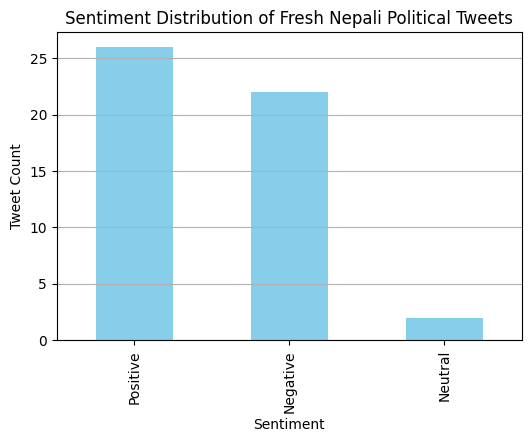

In [ ]:
import matplotlib.pyplot as plt

sentiment_counts = df_results['sentiment'].value_counts()

plt.figure(figsize=(6,4))
sentiment_counts.plot(kind='bar', color='skyblue')
plt.title("Sentiment Distribution of Fresh Nepali Political Tweets")
plt.ylabel("Tweet Count")
plt.xlabel("Sentiment")
plt.grid(axis='y')
plt.show()
